In [1]:
#Main
import pandas as pd
import numpy as np
from math import floor
import time
import pickle
from tqdm import tqdm
from collections import defaultdict

# SKLEARN
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, StratifiedGroupKFold
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import nannyml as nml
colors =  nml.plots.colors.Colors

# METRICS
# Classification 
from sklearn.metrics import balanced_accuracy_score, average_precision_score, roc_auc_score, f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix

# IMBLEARN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# MODEL ARCHITECTURES
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

# TUNING
from optuna.integration import OptunaSearchCV
from optuna import distributions as optdist
from sklearn.metrics import make_scorer
import optuna

#Explainability
import shap

#Fairness
from fairlearn.metrics import (
    demographic_parity_difference, 
    equalized_odds_difference, 
    false_positive_rate_difference,
    false_negative_rate_difference
)

# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

/opt/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100

In [2]:
PAT = '/Users/marinacamacho/Desktop/Master_I/Data_Final'
DIS = "Diabetes_Depression_2"
MOD = "Binary_2"
FET = "45"

In [3]:
# Read trainCohort_{DIS} file
with open(f"{PAT}/trainCohort_{DIS}", "rb") as fp:
    trainData = pickle.load(fp)
# Read trainLabels_{DIS} file
with open(f"{PAT}/trainLabels_{DIS}", "rb") as fp:
    y_train = pickle.load(fp)

# Read externalCohort_{DIS} file
with open(f"{PAT}/externalCohort_{DIS}", "rb") as fp:
    extCohort = pickle.load(fp)
# Read externalLabels_{DIS} file
with open(f"{PAT}/externalLabels_{DIS}", "rb") as fp:
    y_ext = pickle.load(fp)

# Read traceCohort_{DIS} file
with open(f"{PAT}/traceCohort_{DIS}", "rb") as fp:
    traceCohort = pickle.load(fp)
# Read traceLabels_{DIS} file
with open(f"{PAT}/traceLabels_{DIS}", "rb") as fp:
    y_trace = pickle.load(fp)

In [4]:
eids = trainData.reset_index().iloc[:,0].values
targets = pd.DataFrame(y_train["target"])

In [5]:
X_ext = extCohort.values
X_trace = traceCohort.values
X_train = trainData.values

In [6]:
trainData.shape, extCohort.shape, traceCohort.shape

((5874, 174), (2379, 174), (249, 174))

In [7]:
y_train.shape, y_ext.shape, y_trace.shape

((5874, 1), (2379, 1), (249, 1))

In [8]:
y_train['target'].value_counts()

0    5278
1     596
Name: target, dtype: int64

In [9]:
y_ext['target'].value_counts()

0    2101
1     278
Name: target, dtype: int64

In [10]:
y_trace['target'].value_counts()

0    219
1     30
Name: target, dtype: int64

In [11]:
Normalize = False # Flag to determine whether to normalize data or not
OuterFolds = 5 # Number of outer cross-validation folds for model evaluation
InnerFolds = 3 # Number of inner cross-validation folds for hyperparameter tuning
random_state = 28 # Seed for random number generation to ensure reproducibility

In [12]:
# XGBoost Pipeline
XGB = XGBClassifier(random_state=random_state)

XGB_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan,
                            strategy='median')),
    ('RUS', RandomUnderSampler(random_state=random_state)),
    #('SMOTE', SMOTE(random_state=random_state)),
    ('select_features', SelectFromModel(RandomForestClassifier(), threshold='median', max_features=45)),
    ('XGB', XGB)
    ])

# Logistic Regression Pipeline
LReg = LogisticRegression(random_state=random_state)

LReg_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan,
                            strategy='median')),
    ('RUS', RandomUnderSampler(random_state=random_state)),
    #('SMOTE', SMOTE(random_state=random_state)),
    ('select_features', SelectFromModel(RandomForestClassifier(), threshold='median', max_features=45)),
    ('LReg', LReg)
])

# Support Vector Machine Pipeline
SVM = SVC(probability=True, random_state=random_state)

SVM_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan,
                            strategy='median')),
    ('RUS', RandomUnderSampler(random_state=random_state)),
    #('SMOTE', SMOTE(random_state=random_state)),
    ('select_features', SelectFromModel(RandomForestClassifier(), threshold='median', max_features=45)),
    ('SVM', SVM)
])

In [15]:
# Parameter search space for XGBoost model
XGB_params = {
    #'RUS__sampling_strategy': optdist.FloatDistribution(low=0.3, high=0.7),
    #'SMOTE__k_neighbors': optdist.IntDistribution(low=3, high=7, step=2),
    'XGB__learning_rate': optdist.FloatDistribution(low=0.05, high=0.3),
    'XGB__min_child_weight': optdist.IntDistribution(low=1, high=5),
    'XGB__gamma': optdist.FloatDistribution(low=0.5, high=2),
    'XGB__subsample': optdist.FloatDistribution(low=0.6, high=1),
    'XGB__colsample_bytree': optdist.FloatDistribution(low=0.6, high=1),
    'XGB__max_depth': optdist.IntDistribution(low=2, high=12)}

# Parameter search space for Logistic Regression model
LReg_params = {
    #'RUS__sampling_strategy': optdist.FloatDistribution(low=0.3, high=0.7),
    #'SMOTE__k_neighbors': optdist.IntDistribution(low=3, high=7, step=2),
    'LReg__penalty': optdist.CategoricalDistribution(['l2']),
    'LReg__solver': optdist.CategoricalDistribution(['newton-cg', 'lbfgs', 'liblinear']),
    'LReg__max_iter': optdist.IntDistribution(low=100, high=300),
    'LReg__C': optdist.FloatDistribution(low=0, high=100)}

# Parameter search space for Support Vector Machine model
SVM_params = {
    #'RUS__sampling_strategy': optdist.FloatDistribution(low=0.3, high=0.7),
    #'SMOTE__k_neighbors': optdist.IntDistribution(low=3, high=7, step=2),
    'SVM__C': optdist.FloatDistribution(low=0, high=100),
    'SVM__kernel': optdist.CategoricalDistribution(['linear', 'rbf']),
    'SVM__gamma':  optdist.FloatDistribution(low=0.001, high=1),
    'SVM__max_iter': optdist.IntDistribution(low=100, high=300)}

In [16]:
hyperparameters = {'SVM': SVM_params,
                   'LReg': LReg_params,
                   'XGB': XGB_params}

pipelines = {'SVM': SVM_pipeline,
             'LReg': LReg_pipeline,
             'XGB': XGB_pipeline}

In [21]:
inner_scoring = make_scorer(roc_auc_score, needs_proba=True)
skf = StratifiedKFold(n_splits=OuterFolds)

for i, (train_index, val_index) in enumerate(skf.split(trainData, targets)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={val_index}")
    
    fitted_models=dict()
    
    for name, pipeline in pipelines.items():
        print(f"Fitting {name}...")
        foldModels = {i: {
            'model': None,
            'threshold': 0.5
        } for i in range(OuterFolds)}
       
        Outer_start = time.perf_counter()

        for i in tqdm(range(OuterFolds)):
            # Pull training and validation splits for the outer fold 
            train_eids = list(pd.DataFrame(trainData.index).iloc[train_index]['eid'])
            val_eids = list(pd.DataFrame(trainData.index).iloc[val_index]['eid'])

            X_train = trainData.query('eid == @train_eids')
            X_val = trainData.query('eid == @val_eids')

            y_train = targets.query('eid == @train_eids')
            y_val = targets.query('eid == @val_eids')

            Inner_start = time.perf_counter()
            # Perform inner cross validation for hyper parameter tuning
            Inner_CV = OptunaSearchCV(
                estimator=pipeline,
                param_distributions=hyperparameters[name],
                cv=InnerFolds,
                error_score="raise",
                n_trials=5,
                scoring=inner_scoring,
                verbose=False,
                refit=True
            )

            Inner_CV.fit(X_train, y_train)

            best_model = Inner_CV.best_estimator_
            foldModels[i]['model'] = best_model

            # Evaluate optimal threshold on validation set
            pred_thresh = thresholdSelector(best_model, X_val.values, y_val.values, f1_score)
            foldModels[i]['threshold'] = pred_thresh
            foldModels[i]['features'] = foldModels[i]['model']['select_features'].get_support(indices=True)

            Inner_end = time.perf_counter()

        Outer_end = time.perf_counter()
        fitted_models[name] = foldModels
            
    with open(f"{PAT}/{MOD}/fitted_models_{DIS}{FET}", "wb") as fp:
                pickle.dump(fitted_models, fp)

Fold 0:
  Train: index=[1154 1156 1157 ... 5871 5872 5873]
  Test:  index=[   0    1    2 ... 1313 1349 1358]
Fitting SVM...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:11:49,082] A new study created in memory with name: no-name-f63e5df0-a0c9-448c-b3a6-38d9af7d671c
[I 2023-08-18 15:11:50,142] Trial 0 finished with value: 0.5 and parameters: {'SVM__C': 15.042984438010931, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.6826798020627574, 'SVM__max_iter': 131}. Best is trial 0 with value: 0.5.
[I 2023-08-18 15:11:51,517] Trial 1 finished with value: 0.5266080746601198 and parameters: {'SVM__C': 94.59971339910118, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.007957880857556023, 'SVM__max_iter': 239}. Best is trial 1 with value: 0.5266080746601198.
[I 2023-08-18 15:11:52,951] Trial 2 finished with value: 0.5 and parameters: {'SVM__C': 60.51988518524107, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.34309400124854644, 'SVM__max_iter': 283}. Best is

Fitting LReg...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:12:18,448] A new study created in memory with name: no-name-ec9ebc58-b323-4c77-8658-034f8877d433
[I 2023-08-18 15:12:19,593] Trial 0 finished with value: 0.7036512540705901 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 283, 'LReg__C': 4.97311471422055}. Best is trial 0 with value: 0.7036512540705901.
[I 2023-08-18 15:12:20,473] Trial 1 finished with value: 0.7035877722678096 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 249, 'LReg__C': 2.6369142036801296}. Best is trial 0 with value: 0.7036512540705901.
[I 2023-08-18 15:12:21,649] Trial 2 finished with value: 0.700654034215443 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 185, 'LReg__C

Fitting XGB...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:12:43,492] A new study created in memory with name: no-name-b193e7f6-5c53-4a3e-beb7-b2e613c0a2fb
[I 2023-08-18 15:12:45,034] Trial 0 finished with value: 0.6824261713025441 and parameters: {'XGB__learning_rate': 0.1759983430343145, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.9349275104513006, 'XGB__subsample': 0.868028429663572, 'XGB__colsample_bytree': 0.7485268522803663, 'XGB__max_depth': 11}. Best is trial 0 with value: 0.6824261713025441.
[I 2023-08-18 15:12:46,401] Trial 1 finished with value: 0.6893398251466402 and parameters: {'XGB__learning_rate': 0.0873725946507964, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.7871818190836817, 'XGB__subsample': 0.9780621573340591, 'XGB__colsample_bytree': 0.7296835516981919, 'XGB__max_depth': 7}. Best is trial

 80%|███████████████████████████████████████████████████████████████████████▏                 | 4/5 [00:31<00:08,  8.05s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:13:14,805] A new study created in memory with name: no-name-0d384416-f4b2-40ba-96f8-b16a584f2d1a
[I 2023-08-18 15:13:16,537] Trial 0 finished with value: 0.6879866324432996 and parameters: {'XGB__learning_rate': 0.08989421498784812, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.0885643805164478, 'XGB__subsample': 0.7224781573226475, 'XGB__colsample_bytree': 0.7121871403126412, 'XGB__max_depth': 7}. Best is trial 0 with value: 0.6879866324432996.
[I 2023-08-18 15:13:18,079] Trial 1 finished with value: 0.6713392651420672 and parameters: {'XGB__learning_rate': 0.24379201150052943, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.8837170556840301, 'XGB__subsample': 0.6866154347710481, 'XGB__colsample_bytree': 0.6455464992653477, 'XGB__max_depth': 5}. Best is tri

Fold 1:
  Train: index=[   0    1    2 ... 5871 5872 5873]
  Test:  index=[1154 1156 1157 ... 2425 2447 2451]
Fitting SVM...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:13:24,314] A new study created in memory with name: no-name-9893e03b-af2f-4c71-bc2e-02ffc6d7ae06
[I 2023-08-18 15:13:25,767] Trial 0 finished with value: 0.5 and parameters: {'SVM__C': 29.72993927893228, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.5937339649297597, 'SVM__max_iter': 242}. Best is trial 0 with value: 0.5.
[I 2023-08-18 15:13:26,537] Trial 1 finished with value: 0.5206393809120154 and parameters: {'SVM__C': 0.3061148091170862, 'SVM__kernel': 'linear', 'SVM__gamma': 0.12692125440403923, 'SVM__max_iter': 112}. Best is trial 1 with value: 0.5206393809120154.
[I 2023-08-18 15:13:27,323] Trial 2 finished with value: 0.5384523178388463 and parameters: {'SVM__C': 3.0107476827333612, 'SVM__kernel': 'linear', 'SVM__gamma': 0.6752526644460747, 'SVM__max_

Fitting LReg...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:13:51,671] A new study created in memory with name: no-name-0664deac-bc66-4ee0-9e6b-f6d04d9484f0
[I 2023-08-18 15:13:52,992] Trial 0 finished with value: 0.6960920029487863 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 243, 'LReg__C': 51.68015944862384}. Best is trial 0 with value: 0.6960920029487863.
[I 2023-08-18 15:13:54,232] Trial 1 finished with value: 0.6919487210954404 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 290, 'LReg__C': 92.02753357081383}. Best is trial 0 with value: 0.6960920029487863.
[I 2023-08-18 15:13:55,041] Trial 2 finished with value: 0.6942858182473785 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 158, 'LR

Fitting XGB...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:14:17,996] A new study created in memory with name: no-name-bb005534-c224-435b-8205-8bacd3d95299
[I 2023-08-18 15:14:18,900] Trial 0 finished with value: 0.6748101222325033 and parameters: {'XGB__learning_rate': 0.2848598653709432, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.7128057139426512, 'XGB__subsample': 0.6179692293686838, 'XGB__colsample_bytree': 0.7403055396928776, 'XGB__max_depth': 2}. Best is trial 0 with value: 0.6748101222325033.
[I 2023-08-18 15:14:20,024] Trial 1 finished with value: 0.693104082921652 and parameters: {'XGB__learning_rate': 0.09999818693050715, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.7552579710855534, 'XGB__subsample': 0.8144716043009561, 'XGB__colsample_bytree': 0.7185531891850143, 'XGB__max_depth': 5}. Best is trial

invalid value encountered in true_divide
 80%|███████████████████████████████████████████████████████████████████████▏                 | 4/5 [00:25<00:06,  6.39s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:14:43,471] A new study created in memory with name: no-name-2ab11113-d0e8-4acd-a5ff-1cb55a1ccb65
[I 2023-08-18 15:14:44,893] Trial 0 finished with value: 0.684727198286319 and parameters: {'XGB__learning_rate': 0.19524248365251734, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.557832867521893, 'XGB__subsample': 0.7109440851218101, 'XGB__colsample_bytree': 0.7275351589661592, 'XGB__max_depth': 6}. Best is trial 0 with value: 0.684727198286319.
[I 2023-08-18 15:14:46,423] Trial 1 finished with value: 0.6877665657916819 and parameters: {'XGB__learning_rate': 0.09449087574342262, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.8283543505172704, 'XGB__subsample': 0.8277065283732233, 'XGB__colsample_bytree': 0.8440595267913

Fold 2:
  Train: index=[   0    1    2 ... 5871 5872 5873]
  Test:  index=[2337 2338 2340 ... 3524 3525 3527]
Fitting SVM...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:14:51,352] A new study created in memory with name: no-name-0dfa983f-2990-4df9-82ff-cad7b4e2a4aa
[I 2023-08-18 15:14:52,823] Trial 0 finished with value: 0.5 and parameters: {'SVM__C': 86.19191943516542, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.8168782040747001, 'SVM__max_iter': 254}. Best is trial 0 with value: 0.5.
[I 2023-08-18 15:14:54,259] Trial 1 finished with value: 0.5 and parameters: {'SVM__C': 40.500670571650524, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.9195802693658635, 'SVM__max_iter': 258}. Best is trial 0 with value: 0.5.
[I 2023-08-18 15:14:55,336] Trial 2 finished with value: 0.5 and parameters: {'SVM__C': 65.70378665216083, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.48959069006321343, 'SVM__max_iter': 110}. Best is trial 0 with value: 0.5.
[I 202

Fitting LReg...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:15:18,080] A new study created in memory with name: no-name-a8f4d245-3082-4a35-a871-b420c9405c60
[I 2023-08-18 15:15:18,876] Trial 0 finished with value: 0.6988956248935833 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 168, 'LReg__C': 1.6956858553842213}. Best is trial 0 with value: 0.6988956248935833.
[I 2023-08-18 15:15:19,741] Trial 1 finished with value: 0.6885762878903016 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 119, 'LReg__C': 5.577953716947115}. Best is trial 0 with value: 0.6988956248935833.
[I 2023-08-18 15:15:20,633] Trial 2 finished with value: 0.6932754461157552 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 108, 'LReg_

Fitting XGB...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:15:46,937] A new study created in memory with name: no-name-bc2eedf5-5270-46b1-9430-ce7e125bf740
[I 2023-08-18 15:15:48,548] Trial 0 finished with value: 0.6602336577343618 and parameters: {'XGB__learning_rate': 0.2589361697826754, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.1800806599932347, 'XGB__subsample': 0.9367232219752811, 'XGB__colsample_bytree': 0.9028711857356102, 'XGB__max_depth': 7}. Best is trial 0 with value: 0.6602336577343618.
[I 2023-08-18 15:15:50,436] Trial 1 finished with value: 0.6644526737128293 and parameters: {'XGB__learning_rate': 0.168237261316182, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.501392975337221, 'XGB__subsample': 0.8193872255983745, 'XGB__colsample_bytree': 0.6080291116147273, 'XGB__max_depth': 8}. Best is trial 1

 80%|███████████████████████████████████████████████████████████████████████▏                 | 4/5 [00:32<00:07,  7.74s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:16:18,953] A new study created in memory with name: no-name-f7979581-2519-4ead-b11a-5b8e140f0806
[I 2023-08-18 15:16:20,422] Trial 0 finished with value: 0.6711584804221561 and parameters: {'XGB__learning_rate': 0.1942623203159326, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.4300311120312605, 'XGB__subsample': 0.727291561431302, 'XGB__colsample_bytree': 0.7607201703105015, 'XGB__max_depth': 10}. Best is trial 0 with value: 0.6711584804221561.
[I 2023-08-18 15:16:21,644] Trial 1 finished with value: 0.6694172262564088 and parameters: {'XGB__learning_rate': 0.22997372534049138, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.5403192286411642, 'XGB__subsample': 0.9790167094801413, 'XGB__colsample_bytree': 0.6010046434480433, 'XGB__max_depth': 7}. Best is tria

Fold 3:
  Train: index=[   0    1    2 ... 5871 5872 5873]
  Test:  index=[3517 3520 3526 ... 4710 4711 4712]
Fitting SVM...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:16:25,894] A new study created in memory with name: no-name-b2f39451-8cbe-4022-9b83-102eb4c8ea8b
[I 2023-08-18 15:16:27,049] Trial 0 finished with value: 0.5 and parameters: {'SVM__C': 53.79403103806413, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.9425448433852481, 'SVM__max_iter': 135}. Best is trial 0 with value: 0.5.
[I 2023-08-18 15:16:27,855] Trial 1 finished with value: 0.5121591336242802 and parameters: {'SVM__C': 44.417942894546535, 'SVM__kernel': 'linear', 'SVM__gamma': 0.0987571100596516, 'SVM__max_iter': 144}. Best is trial 1 with value: 0.5121591336242802.
[I 2023-08-18 15:16:28,991] Trial 2 finished with value: 0.5 and parameters: {'SVM__C': 35.70820465732639, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.7877626716122612, 'SVM__max_iter': 134}. Best is

Fitting LReg...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:16:52,319] A new study created in memory with name: no-name-1a1e54aa-3a77-4540-ab79-8c7fe9c6211d
[I 2023-08-18 15:16:53,153] Trial 0 finished with value: 0.689934408758237 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 288, 'LReg__C': 94.89759437732555}. Best is trial 0 with value: 0.689934408758237.
[I 2023-08-18 15:16:53,925] Trial 1 finished with value: 0.6824698974876909 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 134, 'LReg__C': 61.56988008670628}. Best is trial 0 with value: 0.689934408758237.
[I 2023-08-18 15:16:54,796] Trial 2 finished with value: 0.6862229743163092 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 261, 'LReg__C': 92.

Fitting XGB...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:17:19,983] A new study created in memory with name: no-name-5bf35523-49b1-499e-bf49-fbf542562732
[I 2023-08-18 15:17:21,429] Trial 0 finished with value: 0.6546863455346653 and parameters: {'XGB__learning_rate': 0.18527970199761612, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.6549616569338235, 'XGB__subsample': 0.6894885587284236, 'XGB__colsample_bytree': 0.7211730054191371, 'XGB__max_depth': 7}. Best is trial 0 with value: 0.6546863455346653.
[I 2023-08-18 15:17:22,572] Trial 1 finished with value: 0.6549497399300361 and parameters: {'XGB__learning_rate': 0.16515310398170485, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.5103765525111426, 'XGB__subsample': 0.7891516741845809, 'XGB__colsample_bytree': 0.8555591725858877, 'XGB__max_depth': 3}. Best is tri

 80%|███████████████████████████████████████████████████████████████████████▏                 | 4/5 [00:29<00:07,  7.79s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:17:49,801] A new study created in memory with name: no-name-3c490123-5597-4534-9de5-033d8e59d7f7
[I 2023-08-18 15:17:50,960] Trial 0 finished with value: 0.6568638065317943 and parameters: {'XGB__learning_rate': 0.18179801689719627, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.8796599797870622, 'XGB__subsample': 0.8351561804946255, 'XGB__colsample_bytree': 0.6424152823398758, 'XGB__max_depth': 2}. Best is trial 0 with value: 0.6568638065317943.
[I 2023-08-18 15:17:52,066] Trial 1 finished with value: 0.6501611800329942 and parameters: {'XGB__learning_rate': 0.2760661314548766, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.6977065494561854, 'XGB__subsample': 0.8343156295915306, 'XGB__colsample_bytree': 0.9646211971040981, 'XGB__max_depth': 2}. Best is tria

Fold 4:
  Train: index=[   0    1    2 ... 4710 4711 4712]
  Test:  index=[4570 4584 4591 ... 5871 5872 5873]
Fitting SVM...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:17:57,597] A new study created in memory with name: no-name-7e5e6858-bef0-4eeb-a4ab-8fcef56c0756
[I 2023-08-18 15:17:58,489] Trial 0 finished with value: 0.5327153721433061 and parameters: {'SVM__C': 1.2849599778534504, 'SVM__kernel': 'linear', 'SVM__gamma': 0.24454788730215538, 'SVM__max_iter': 284}. Best is trial 0 with value: 0.5327153721433061.
[I 2023-08-18 15:17:59,306] Trial 1 finished with value: 0.5052257990833832 and parameters: {'SVM__C': 64.09118778092842, 'SVM__kernel': 'linear', 'SVM__gamma': 0.6240501708833858, 'SVM__max_iter': 106}. Best is trial 0 with value: 0.5327153721433061.
[I 2023-08-18 15:18:00,938] Trial 2 finished with value: 0.5 and parameters: {'SVM__C': 56.55610997148604, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.28217387435028

Fitting LReg...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:18:29,787] A new study created in memory with name: no-name-08a52fd7-720f-4242-9c2d-2f598d49c203
[I 2023-08-18 15:18:31,431] Trial 0 finished with value: 0.7070351681398747 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 161, 'LReg__C': 97.70923758428202}. Best is trial 0 with value: 0.7070351681398747.
[I 2023-08-18 15:18:32,243] Trial 1 finished with value: 0.7049405120437048 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 112, 'LReg__C': 0.9161411229146044}. Best is trial 0 with value: 0.7070351681398747.
[I 2023-08-18 15:18:33,138] Trial 2 finished with value: 0.705372656680387 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 144, 'LR

Fitting XGB...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:18:57,896] A new study created in memory with name: no-name-5e72a159-edec-49fc-b327-5a8ae4b6efe8
[I 2023-08-18 15:18:59,251] Trial 0 finished with value: 0.6761816574391378 and parameters: {'XGB__learning_rate': 0.2675978847422338, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.067826067474539, 'XGB__subsample': 0.8890476182643899, 'XGB__colsample_bytree': 0.7593023945901172, 'XGB__max_depth': 8}. Best is trial 0 with value: 0.6761816574391378.
[I 2023-08-18 15:19:00,590] Trial 1 finished with value: 0.6951614762112684 and parameters: {'XGB__learning_rate': 0.13425702825051367, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.9994695535145852, 'XGB__subsample': 0.9432808526546486, 'XGB__colsample_bytree': 0.8585884434992066, 'XGB__max_depth': 7}. Best is trial

invalid value encountered in true_divide
 80%|███████████████████████████████████████████████████████████████████████▏                 | 4/5 [00:29<00:07,  7.77s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:19:27,586] A new study created in memory with name: no-name-a8000eed-3ed2-4865-8305-9d1aa52c200a
[I 2023-08-18 15:19:29,097] Trial 0 finished with value: 0.6847703025870269 and parameters: {'XGB__learning_rate': 0.24726572109917977, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.3966655967796757, 'XGB__subsample': 0.6502854207345291, 'XGB__colsample_bytree': 0.7781147935513779, 'XGB__max_depth': 12}. Best is trial 0 with value: 0.6847703025870269.
[I 2023-08-18 15:19:30,300] Trial 1 finished with value: 0.7093573409091926 and parameters: {'XGB__learning_rate': 0.07789932692518826, 'XGB__min_child_weight': 2, 'XGB__gamma': 0.6837460077621547, 'XGB__subsample': 0.6818655227791098, 'XGB__colsample_bytree': 0.866892734

In [17]:
with open(f"{PAT}/{MOD}/fitted_models_{DIS}{FET}", "rb") as fp:
    models = pickle.load(fp)

In [18]:
def scoring(models, data, ground, score_func):
        return [thresholdPredictor(model=models[i]["model"],
            X=data,
            ground=ground,
            threshold=models[i]["threshold"],
            score_func=score_func) for i in range(OuterFolds)]

In [19]:
dataset0_X, dataset0_y = X_train, y_train
dataset1_X, dataset1_y = X_ext, y_ext
dataset2_X, dataset2_y = X_trace, y_trace

results = {
    "Model": [],
    "Dataset": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "Balanced Accuracy": [],   
}

for model_name, model_variants in models.items():
    for variant, model_info in model_variants.items():
        pipeline = model_info['model']
        threshold = model_info['threshold']
        
        #for dataset_name, (X, y) in [('Training set', (dataset0_X, dataset0_y)),('External set I', (dataset1_X, dataset1_y)), ('External set II', (dataset2_X, dataset2_y))]:
        for dataset_name, (X, y) in [('External set I', (dataset1_X, dataset1_y)), ('External set II', (dataset2_X, dataset2_y))]:


            # Obtain probabilities and predict based on the threshold
            y_prob = pipeline.predict_proba(X)[:, 1]
            y_pred = [1 if prob > threshold else 0 for prob in y_prob]

            report = classification_report(y, y_pred, output_dict=True, zero_division=0)

            # Balanced Accuracy
            bal_acc = balanced_accuracy_score(y, y_pred)

            # Assuming a binary classification, you can adjust as per your classes
            average_results = report['weighted avg']

            results["Model"].append(f"{model_name}_{variant}")
            results["Dataset"].append(dataset_name)
            results["Precision"].append(average_results['precision'])
            results["Recall"].append(average_results['recall'])
            results["F1-Score"].append(average_results['f1-score'])
            results["Balanced Accuracy"].append(bal_acc)  # Add this line to store Balanced Accuracy

df = pd.DataFrame(results)

# Display without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

print(df)

# Save the DataFrame to an Excel file
filename = f"model_results_{DIS}_{FET}.xlsx"
df.to_excel(filename, index=False)
print(f"Results saved to {filename}")

     Model          Dataset  Precision    Recall  F1-Score  Balanced Accuracy
0   SVM_0   External set I   0.455190   0.116856  0.025223  0.498439         
1   SVM_0   External set II  0.014516   0.120482  0.025910  0.500000         
2   SVM_1   External set I   0.792168   0.710383  0.746391  0.495824         
3   SVM_1   External set II  0.781333   0.746988  0.763329  0.482192         
4   SVM_2   External set I   0.013612   0.116435  0.024374  0.498201         
5   SVM_2   External set II  0.014516   0.120482  0.025910  0.500000         
6   SVM_3   External set I   0.774925   0.134510  0.065185  0.497511         
7   SVM_3   External set II  0.600549   0.124498  0.041166  0.487900         
8   SVM_4   External set I   0.793691   0.709962  0.746604  0.500268         
9   SVM_4   External set II  0.786790   0.746988  0.765647  0.496575         
10  LReg_0  External set I   0.841230   0.831021  0.835880  0.621866         
11  LReg_0  External set II  0.896185   0.903614  0.898911  0.72

In [20]:
# Find the best model for Dataset1 based on F1-Score
best_model_idx_dataset1 = df[df['Dataset'] == 'External set I']['F1-Score'].idxmax()
best_model_info_dataset1 = df.loc[best_model_idx_dataset1]

print("Best Model for Dataset1 based on F1-Score:")
print(best_model_info_dataset1)
print("\n")  # just to create a gap between outputs

Best Model for Dataset1 based on F1-Score:
Model                XGB_1         
Dataset              External set I
Precision            0.833241      
Recall               0.848676      
F1-Score             0.84028       
Balanced Accuracy    0.585044      
Name: 22, dtype: object




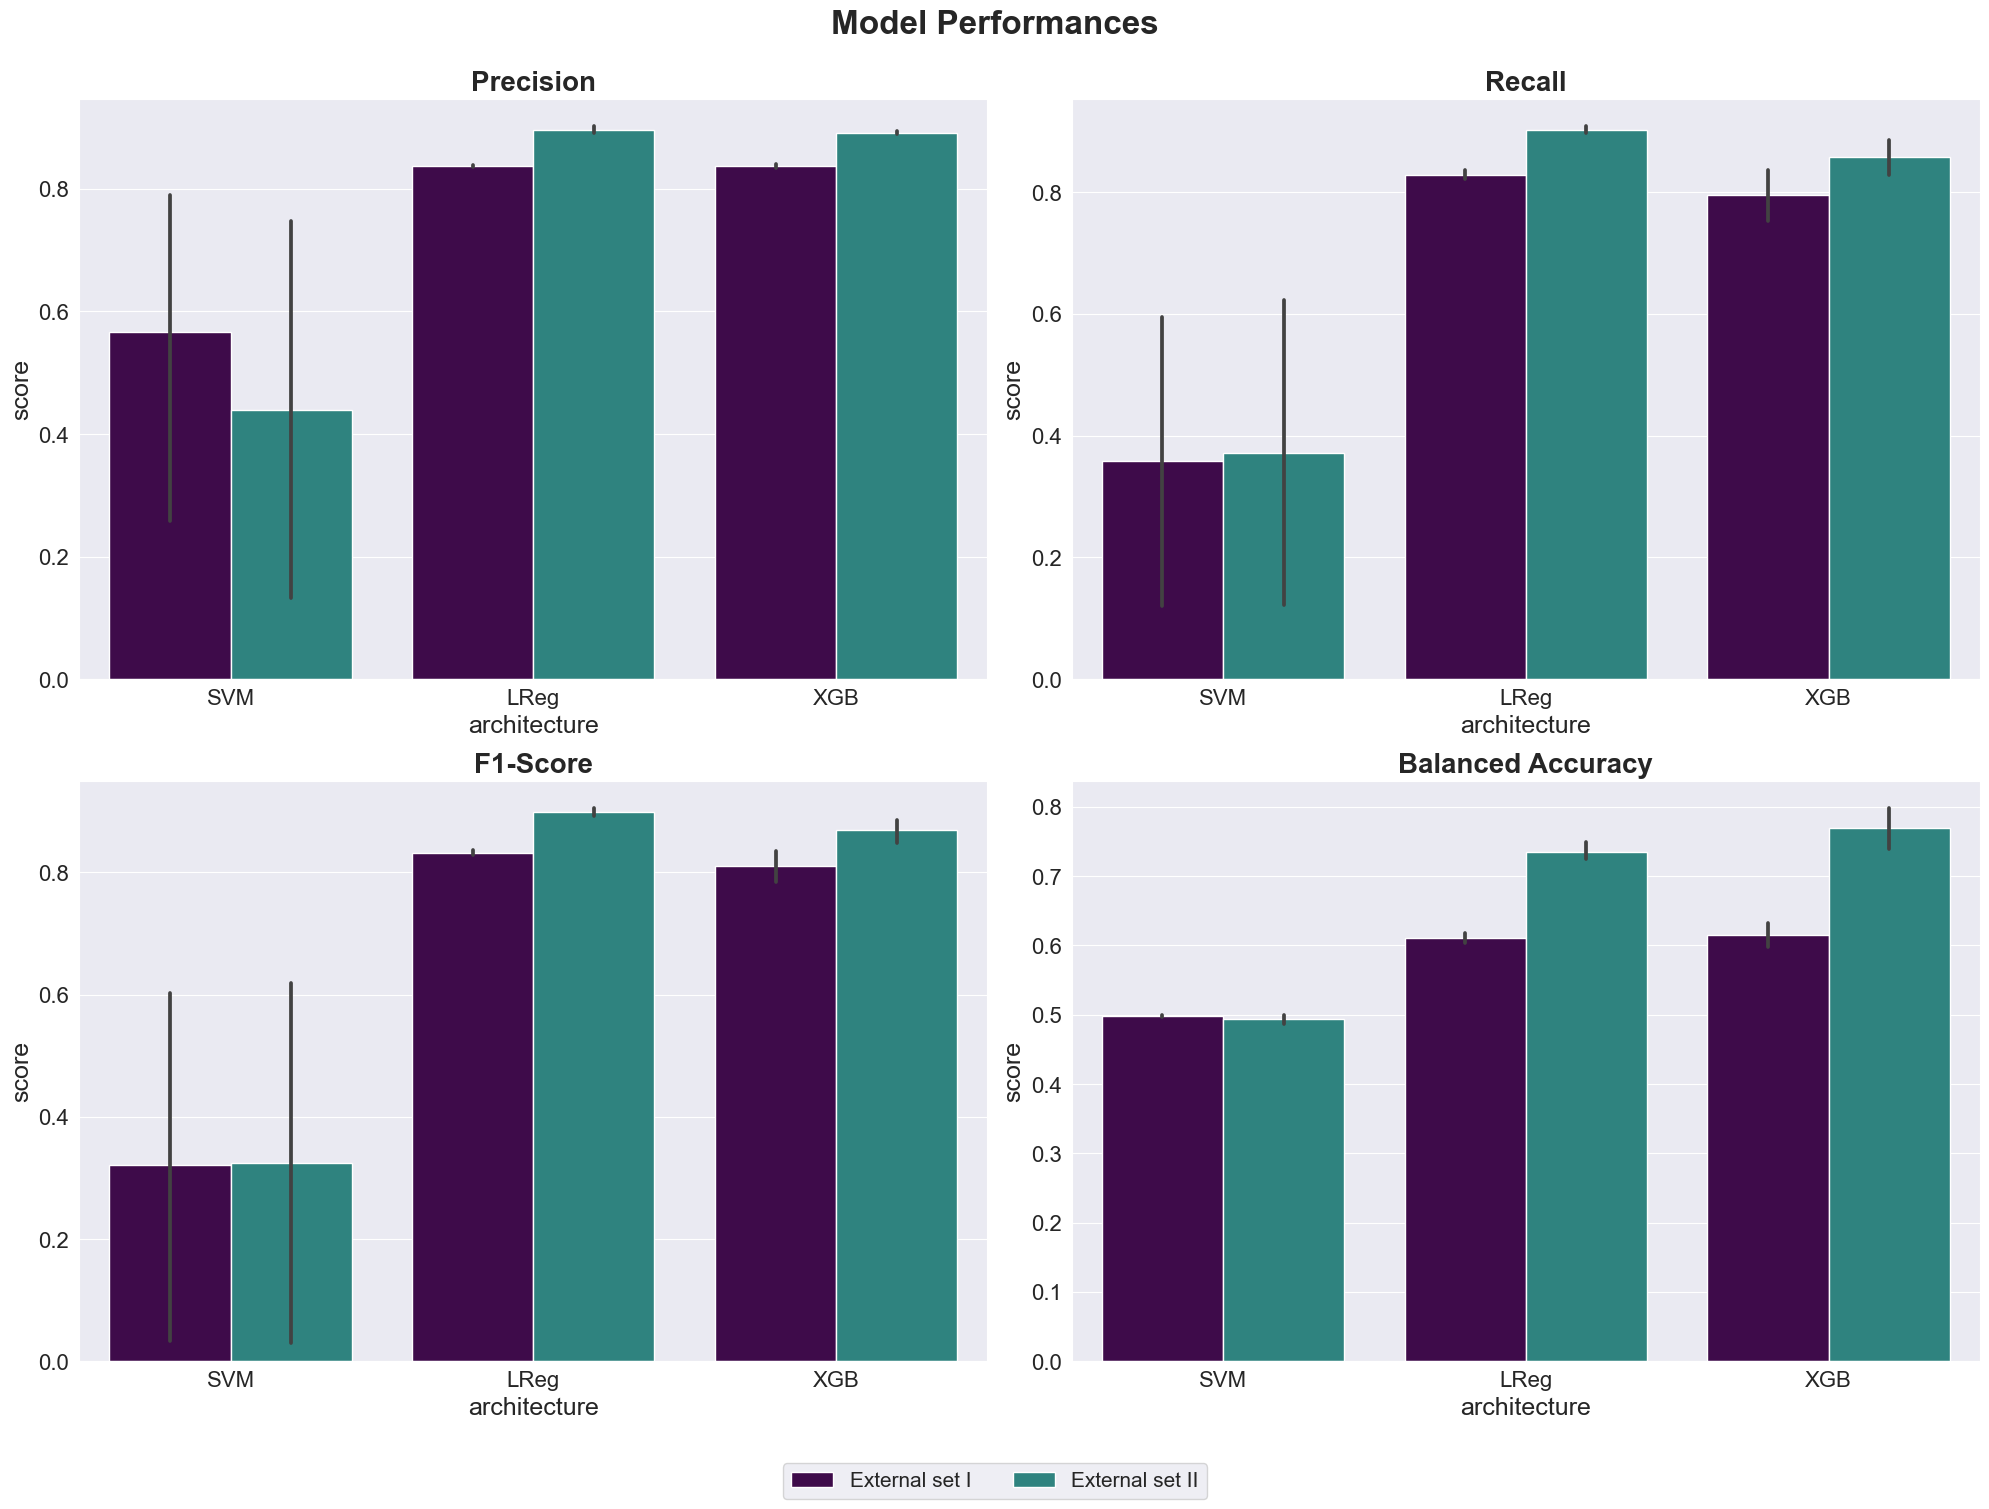

In [21]:
# Remove strings after "_"
df['Model'] = df['Model'].str.split('_').str[0]

# Use the seaborn darkgrid style
sns.set_style("darkgrid")

# List of metrics
metrics = ['Precision', 'Recall', 'F1-Score', 'Balanced Accuracy']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

handles, labels = None, None

# Custom palette
palette_colors = ['#440154', '#21918C', '#FDE725']

# Loop through each metric and create a subplot for each one
for ax, metric in zip(axes.ravel(), metrics):
    bars = sns.barplot(x='Model', y=metric, hue='Dataset', data=df, ax=ax, palette=palette_colors)
    
    # Bold the metric titles
    ax.set_title(metric, fontsize=20, fontweight='bold')
    
    ax.set_ylabel('score', fontsize=18)
    ax.set_xlabel('architecture', fontsize=18)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend().set_visible(False)  # hide the individual legend
    
    if handles is None:
        handles, labels = ax.get_legend_handles_labels()

# Add an overall title closer to the subplots
fig.suptitle('Model Performances', fontsize=24, fontweight='bold', y=0.95)

# Add a centralized legend closer to the plots
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=15, frameon=True, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/final_model_performance_plot{DIS}{FET}.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
best_model = models[best_model_info_dataset1[0][:-2]][int(best_model_info_dataset1[0][-1:])]
best_feats = trainData.iloc[:,best_model['features']].columns

probs = best_model['model'].predict_proba(X_ext)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)
print(classification_report(y_true=y_ext,
                        y_pred=preds))

with open(f"{PAT}/{MOD}/best_model_ext{DIS}{FET}", "wb") as fp:
    pickle.dump(best_model, fp)

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      2101
           1       0.31      0.24      0.27       278

    accuracy                           0.85      2379
   macro avg       0.61      0.59      0.59      2379
weighted avg       0.83      0.85      0.84      2379



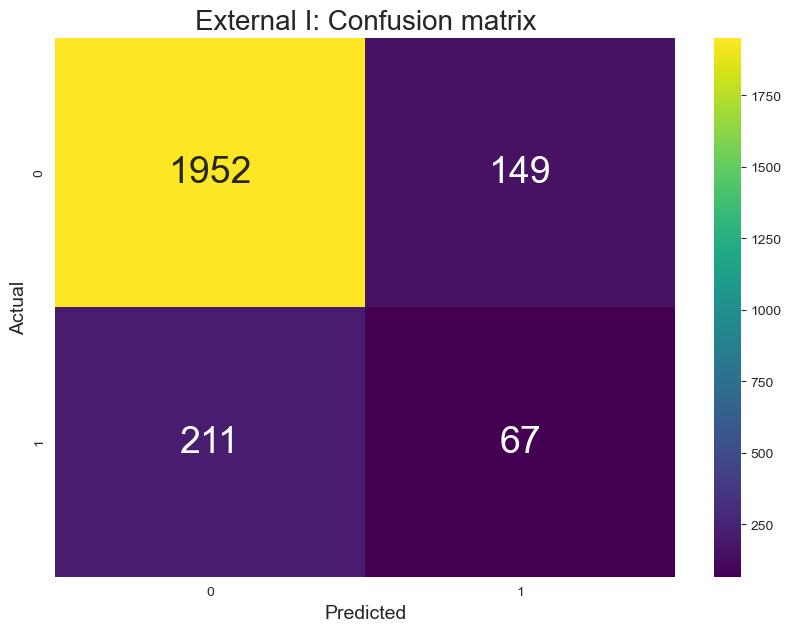

In [23]:
probs = best_model['model'].predict_proba(X_ext)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)

cm = confusion_matrix(y_ext, preds) 


plt.figure(figsize=(10,7))
plt.title("External I: Confusion matrix", fontsize=20)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", annot_kws={"size": 27})  # Adjust the font size here
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)

# Save the figure in high resolution
plt.savefig(f"{PAT}/{MOD}/final_confusion_matrix_ext{DIS}{FET}.png", dpi=300)

plt.show()

In [24]:
probs = best_model['model'].predict_proba(X_trace)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)

print(classification_report(y_true=y_trace,
                        y_pred=preds))

with open(f"{PAT}/{MOD}/best_model_trace{DIS}{FET}", "wb") as fp:
    pickle.dump(best_model, fp)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       219
           1       0.58      0.47      0.52        30

    accuracy                           0.90       249
   macro avg       0.76      0.71      0.73       249
weighted avg       0.89      0.90      0.89       249



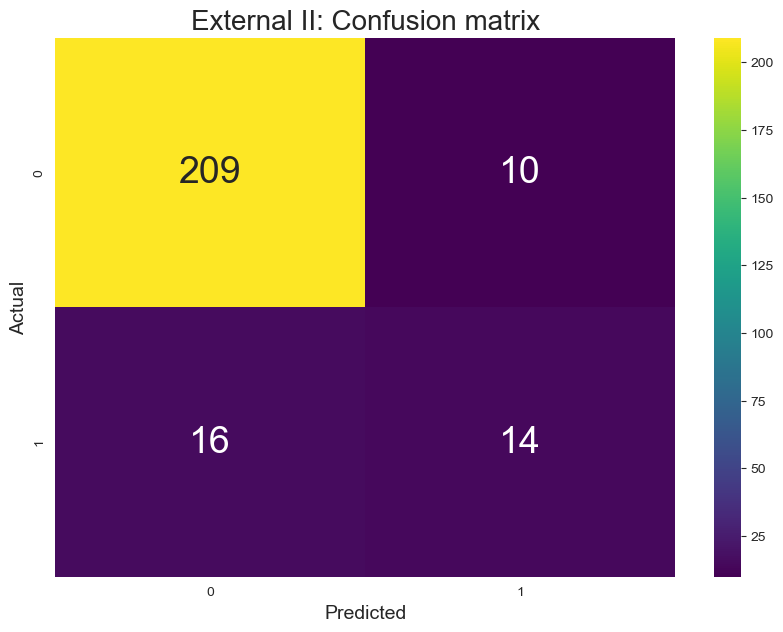

In [25]:
probs = best_model['model'].predict_proba(X_trace)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)

cm = confusion_matrix(y_trace, preds) 
plt.figure(figsize=(10,7))
plt.title("External II: Confusion matrix", fontsize=20)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", annot_kws={"size": 27})  # Adjust the font size here
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)

# Save the figure in high resolution
plt.savefig(f"{PAT}/{MOD}/final_confusion_matrix_trace{DIS}{FET}.png", dpi=300)

plt.show()

In [26]:
best_feats

Index(['APOA', 'APOB', 'Age', 'BMI', 'Bread_intake', 'CRP', 'Cereal_intake',
       'Cholesterol', 'Coffee_intake', 'Cooked_vegetable_intake',
       'Dried_fruit_intake', 'Fasting_time', 'Fed-up_feelings',
       'Frequency_friend_family_visits', 'Fresh_fruit_intake',
       'Getting_up_in_morning', 'Glucose', 'Guilty_feelings', 'HDL', 'HbA1c',
       'Hip_circumference', 'IGF_1', 'Mean_time_to_identify_matches',
       'Miserableness', 'Mood_swings', 'Morning_evening_person',
       'Number_operation', 'Oily_fish_intake', 'Overall_health_rating',
       'Salad/raw_vegetable_intake', 'Sleep_duration', 'Standing_height',
       'Suffer_from_nerves', 'Tea_intake', 'Tenseness_2weeks', 'Testosterone',
       'Time_outdoors_summer', 'Time_outdoors_winter', 'Tiredness_2weeks',
       'Triglyceride', 'Unenthusiasm_2weeks', 'Use_of_sun/uv_protection',
       'Waist_circumference', 'Water_intake', 'Weight'],
      dtype='object')

In [63]:
# Plot the SHAP values for a single prediction (for example, the first instance)
shap.initjs()

In [64]:
import matplotlib.colors as mcolors

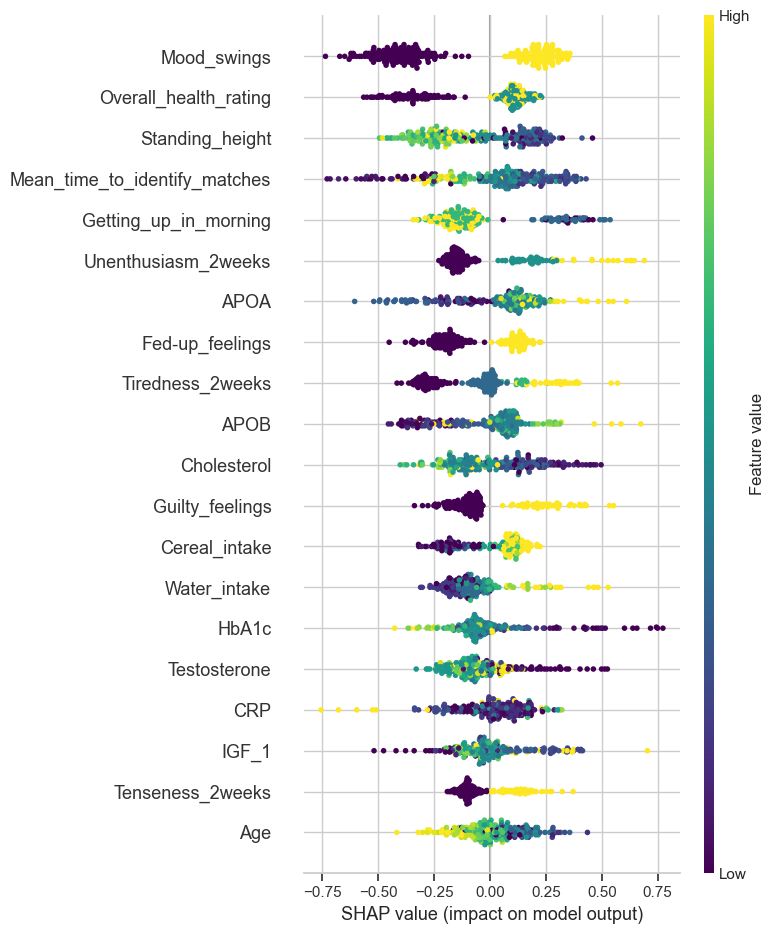

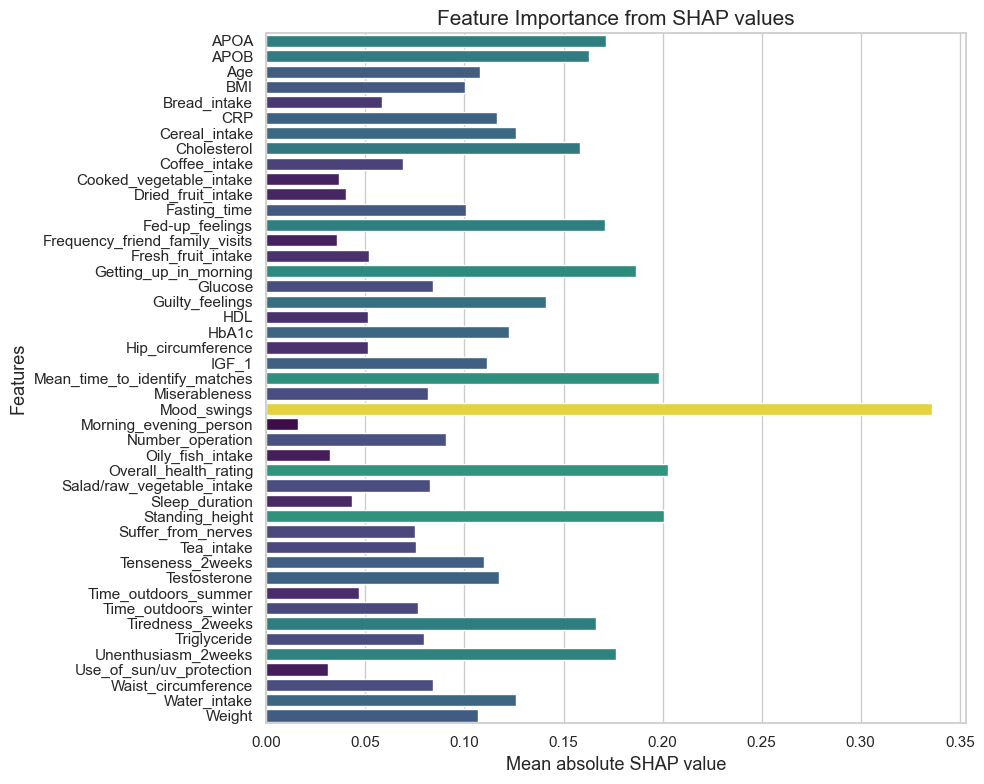

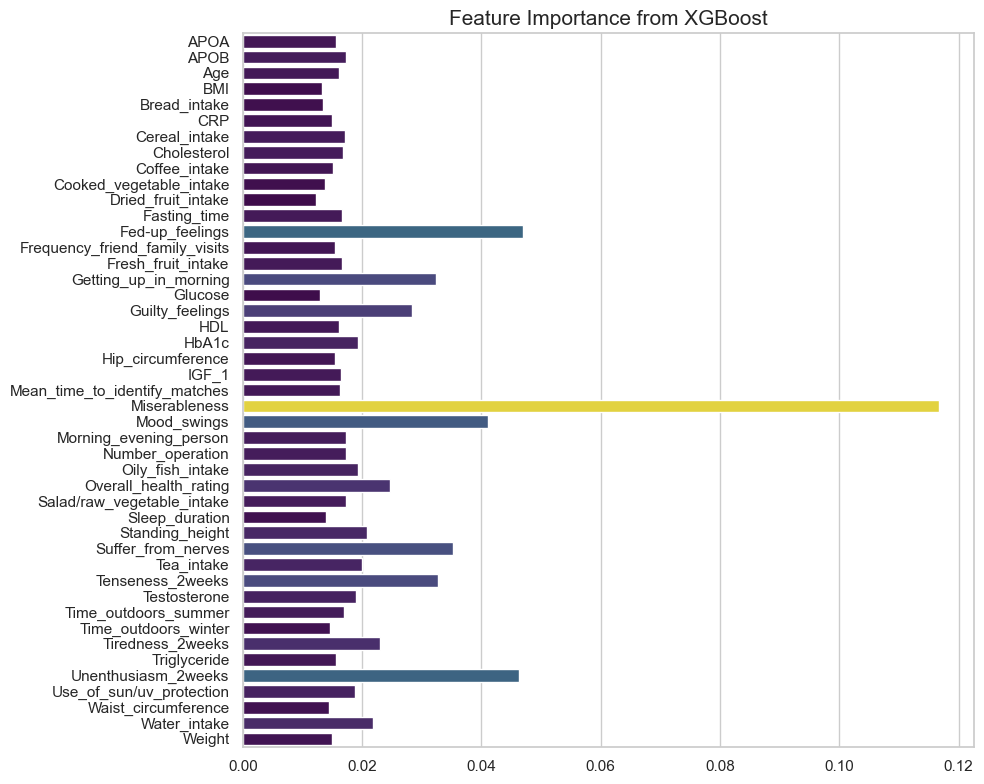

In [75]:
# First, manually apply transformations in the pipeline to the data
X_temp = X_trace.copy()

# Apply imputation
imputer = best_model['model'].named_steps['impute']
X_temp = imputer.transform(X_temp)

# Apply feature selection
selector = best_model['model'].named_steps['select_features']
X_temp = selector.transform(X_temp)

# Now, X_temp contains the transformed data. Use this with the XGB model for SHAP values
xgb_model = best_model['model'].named_steps['XGB']

# Initialize SHAP for the XGB model
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_temp)


#############################################################################
#############################################################################
fig, ax = plt.subplots(figsize=(10, 8))

# Create a colormap that maps from SHAP values to magma colors
max_val = np.abs(shap_values).max()
colors = plt.get_cmap('viridis')  # Change from 'viridis' to 'magma' or 'plasma'
shap_colors = [colors(i) for i in np.linspace(0, 1, 256)]
cmap = mcolors.LinearSegmentedColormap.from_list("shap_viridis", shap_colors)  # Rename to "shap_magma" or "shap_plasma"

# Use the created axis in the shap.summary_plot with modified color
shap.summary_plot(shap_values, X_temp, feature_names=list(best_feats), cmap=cmap)

# Now save this figure
fig.tight_layout()
fig.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/shap_summary_plot_trace{DIS}{FET}.png', dpi=300)

# And finally show the plot
plt.show()

#############################################################################
#############################################################################
# Compute mean absolute SHAP values for each feature
shap_summary = np.abs(shap_values).mean(axis=0)

# Normalize shap_summary to [0,1]
norm_shap_summary = (shap_summary - min(shap_summary)) / (max(shap_summary) - min(shap_summary))

# Generate color array based on normalized shap values
colors_shap = plt.get_cmap('viridis')(norm_shap_summary)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(y=best_feats, x=shap_summary, palette=colors_shap)
plt.xlabel('Mean absolute SHAP value', fontsize=13)
plt.ylabel('Features', fontsize=13)
plt.title('Feature Importance from SHAP values', fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/shap_feature_importance_trace{DIS}{FET}.png', dpi=300)
plt.show()


#############################################################################
#############################################################################
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Get feature importances and normalize to [0,1]
importances = xgb_model.feature_importances_
norm_importances = (importances - min(importances)) / (max(importances) - min(importances))

# Generate color array based on normalized importance values
colors = plt.get_cmap('viridis')(norm_importances)

# Plot using seaborn's barplot
sns.barplot(y=best_feats, x=importances, palette=colors)
plt.title("Feature Importance from XGBoost", fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/xgboost_feature_importance_trace{DIS}{FET}.png', dpi=300)
plt.show()

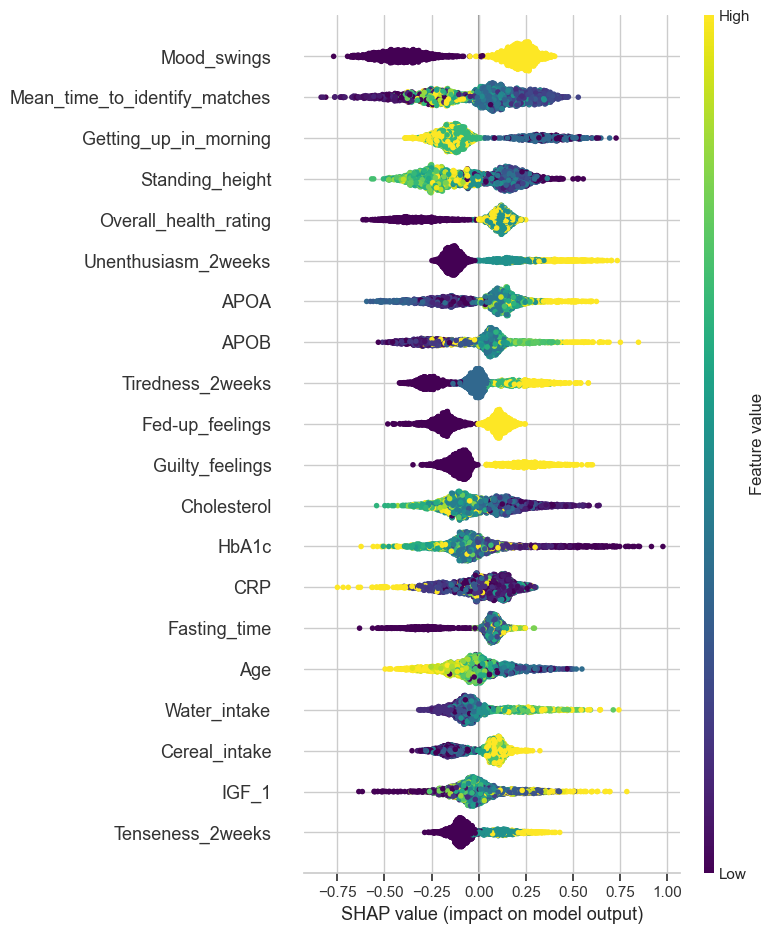

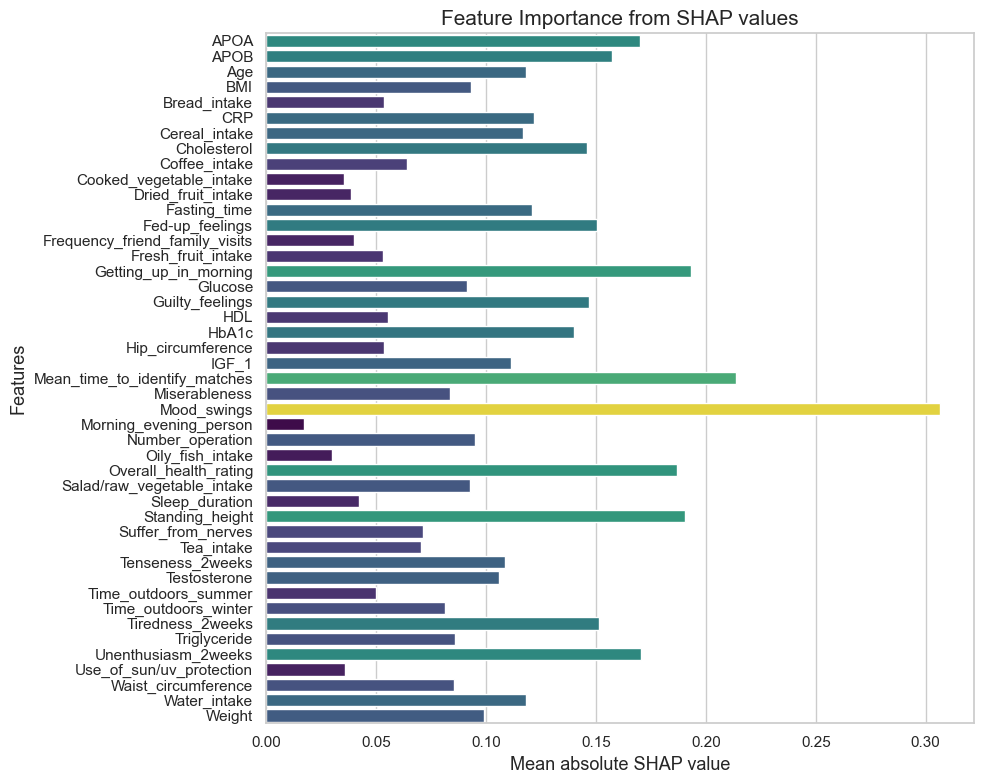

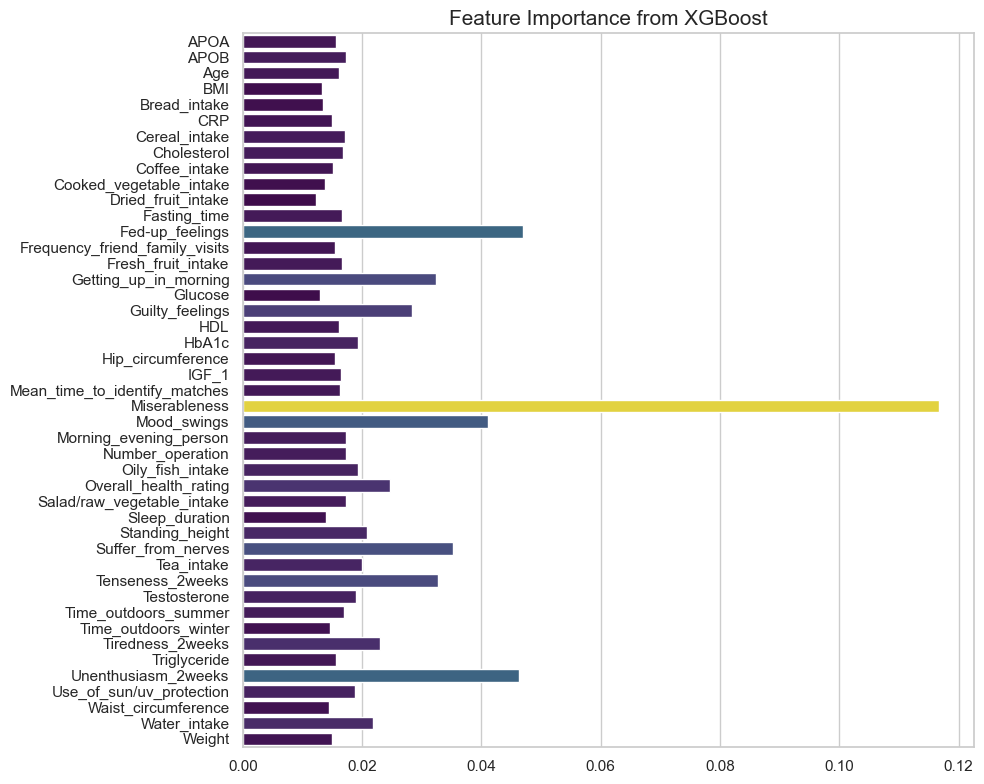

In [66]:
# First, manually apply transformations in the pipeline to the data
X_temp = X_ext.copy()

# Apply imputation
imputer = best_model['model'].named_steps['impute']
X_temp = imputer.transform(X_temp)

# Apply feature selection
selector = best_model['model'].named_steps['select_features']
X_temp = selector.transform(X_temp)

# Now, X_temp contains the transformed data. Use this with the XGB model for SHAP values
xgb_model = best_model['model'].named_steps['XGB']

# Initialize SHAP for the XGB model
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_temp)


#############################################################################
#############################################################################
fig, ax = plt.subplots(figsize=(10, 8))

# Create a colormap that maps from SHAP values to magma colors
max_val = np.abs(shap_values).max()
colors = plt.get_cmap('viridis')  # Change from 'viridis' to 'magma'
shap_colors = [colors(i) for i in np.linspace(0, 1, 256)]
cmap = mcolors.LinearSegmentedColormap.from_list("shap_viridis", shap_colors)  # Rename to "shap_magma"

# Use the created axis in the shap.summary_plot with modified color
shap.summary_plot(shap_values, X_temp, feature_names=list(best_feats), cmap=cmap)

# Now save this figure
fig.tight_layout()
fig.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/shap_summary_plot_ext{DIS}{FET}.png', dpi=300)

# And finally show the plot
plt.show()

#############################################################################
#############################################################################
# Compute mean absolute SHAP values for each feature
shap_summary = np.abs(shap_values).mean(axis=0)

# Normalize shap_summary to [0,1]
norm_shap_summary = (shap_summary - min(shap_summary)) / (max(shap_summary) - min(shap_summary))

# Generate color array based on normalized shap values
colors_shap = plt.get_cmap('viridis')(norm_shap_summary)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(y=best_feats, x=shap_summary, palette=colors_shap)
plt.xlabel('Mean absolute SHAP value', fontsize=13)
plt.ylabel('Features', fontsize=13)
plt.title('Feature Importance from SHAP values', fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/shap_feature_importance_ext{DIS}{FET}.png', dpi=300)
plt.show()

#############################################################################
#############################################################################
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Get feature importances and normalize to [0,1]
importances = xgb_model.feature_importances_
norm_importances = (importances - min(importances)) / (max(importances) - min(importances))

# Generate color array based on normalized importance values
colors = plt.get_cmap('viridis')(norm_importances)

# Plot using seaborn's barplot
sns.barplot(y=best_feats, x=importances, palette=colors)
plt.title("Feature Importance from XGBoost", fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/xgboost_feature_importance_ext{DIS}{FET}.png', dpi=300)
plt.show()

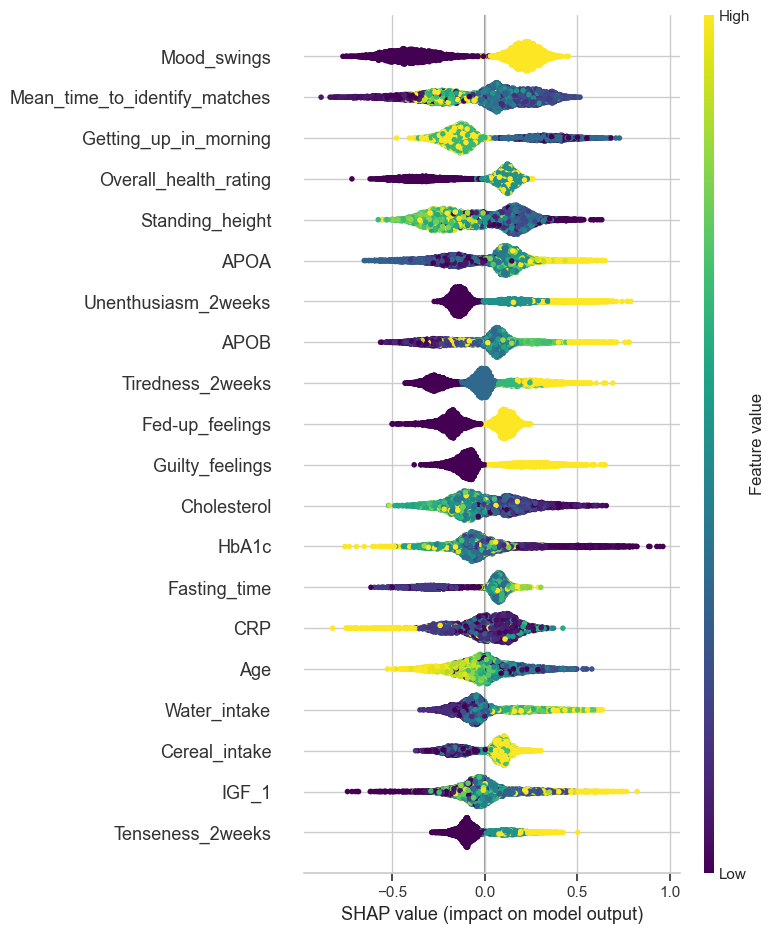

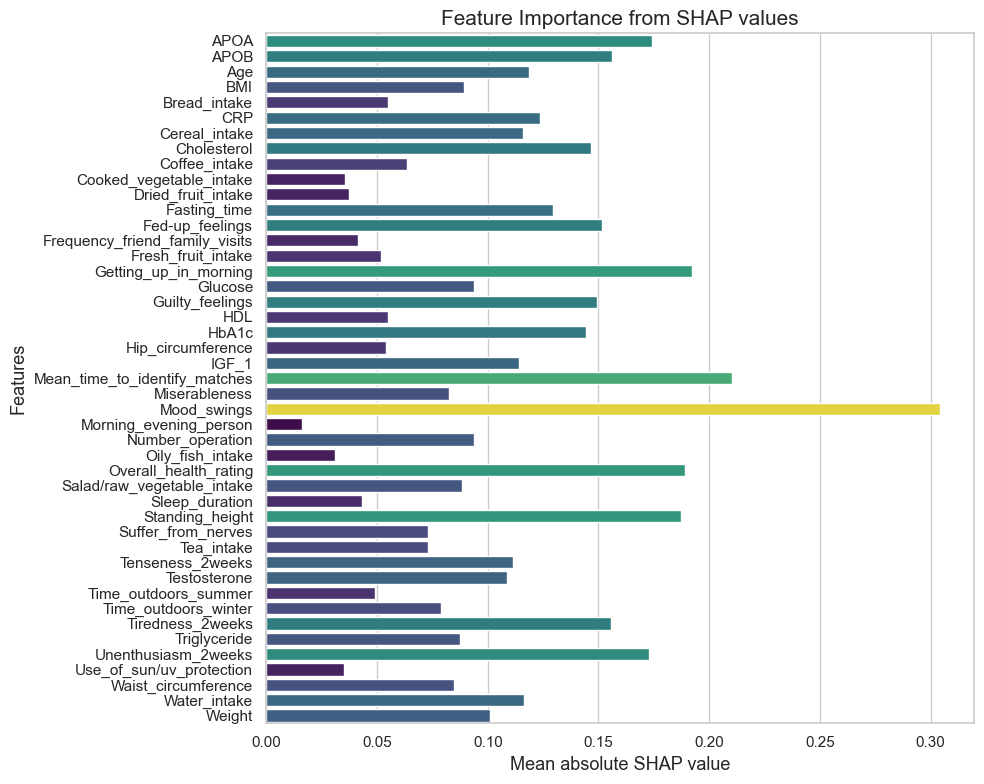

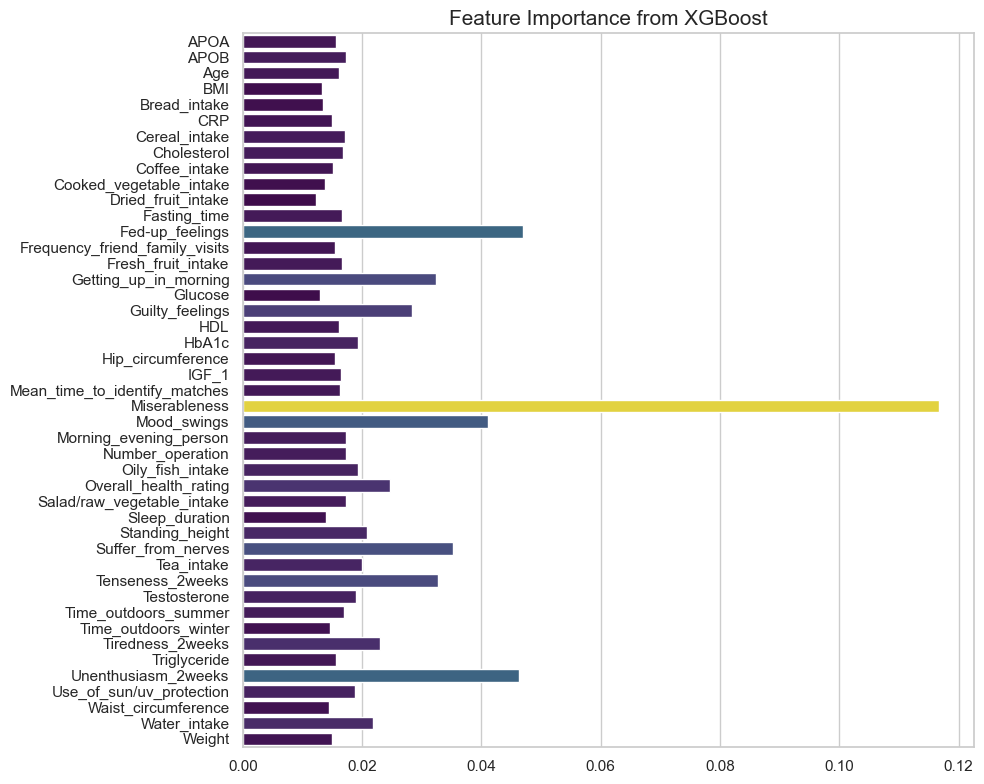

In [67]:
# First, manually apply transformations in the pipeline to the data
X_temp = trainData.copy()

# Apply imputation
imputer = best_model['model'].named_steps['impute']
X_temp = imputer.transform(X_temp)

# Apply feature selection
selector = best_model['model'].named_steps['select_features']
X_temp = selector.transform(X_temp)

# Now, X_temp contains the transformed data. Use this with the XGB model for SHAP values
xgb_model = best_model['model'].named_steps['XGB']

# Initialize SHAP for the XGB model
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_temp)


#############################################################################
#############################################################################
fig, ax = plt.subplots(figsize=(10, 8))

# Create a colormap that maps from SHAP values to magma colors
max_val = np.abs(shap_values).max()
colors = plt.get_cmap('viridis')  # Change from 'viridis' to 'magma'
shap_colors = [colors(i) for i in np.linspace(0, 1, 256)]
cmap = mcolors.LinearSegmentedColormap.from_list("shap_viridis", shap_colors)  # Rename to "shap_magma"

# Use the created axis in the shap.summary_plot with modified color
shap.summary_plot(shap_values, X_temp, feature_names=list(best_feats), cmap=cmap)

# Now save this figure
fig.tight_layout()
fig.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/shap_summary_plot_train{DIS}{FET}.png', dpi=300)

# And finally show the plot
plt.show()
#############################################################################
#############################################################################
# Compute mean absolute SHAP values for each feature
shap_summary = np.abs(shap_values).mean(axis=0)

# Normalize shap_summary to [0,1]
norm_shap_summary = (shap_summary - min(shap_summary)) / (max(shap_summary) - min(shap_summary))

# Generate color array based on normalized shap values
colors_shap = plt.get_cmap('viridis')(norm_shap_summary)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(y=best_feats, x=shap_summary, palette=colors_shap)
plt.xlabel('Mean absolute SHAP value', fontsize=13)
plt.ylabel('Features', fontsize=13)
plt.title('Feature Importance from SHAP values', fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/shap_feature_importance_train{DIS}{FET}.png', dpi=300)
plt.show()

#############################################################################
#############################################################################
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Get feature importances and normalize to [0,1]
importances = xgb_model.feature_importances_
norm_importances = (importances - min(importances)) / (max(importances) - min(importances))

# Generate color array based on normalized importance values
colors = plt.get_cmap('viridis')(norm_importances)

# Plot using seaborn's barplot
sns.barplot(y=best_feats, x=importances, palette=colors)
plt.title("Feature Importance from XGBoost", fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/xgboost_feature_importance_train{DIS}{FET}.png', dpi=300)
plt.show()

In [27]:
LOAD = "/Users/marinacamacho/Desktop/Master_I/Raw_Data"
Cols = ["f.eid","Ethnic", "Skin_colour", "Sex"]
# Exposome data
fair = pd.read_csv(f'{LOAD}/Time_0/all_exposome_0.csv', usecols=lambda col: col in Cols)
fair = fair.set_index('f.eid')
fair = fair.sort_index(axis=1)
fair.index.name = 'eid'

fair2 = pd.read_csv(f'{LOAD}/Time_1/all_exposome_1.csv', usecols=lambda col: col in Cols)
fair2 = fair2.set_index('f.eid')
fair2 = fair2.sort_index(axis=1)
fair2.index.name = 'eid'

fair['Skin_colour'] = fair['Skin_colour'].replace([1,2,3,4,5,6,-1,-3],[0,0,0,0,1,1,np.nan,np.nan])   
fair2['Skin_colour'] = fair2['Skin_colour'].replace([1,2,3,4,5,6,-1,-3],[0,0,0,0,1,1,np.nan,np.nan])    

fair['Ethnic'] = fair['Ethnic'].replace([1,1001,1002,1003],[0,0,0,0])   
fair['Ethnic'] = fair['Ethnic'].replace([2,2001,2002,2003,2004,3,3001,3002,3003,3004,4,4001,4002,4003,5],[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])   
fair['Ethnic'] = fair['Ethnic'].replace([6,-1,-3],[np.nan,np.nan,np.nan])   

fair2['Ethnic'] = fair2['Ethnic'].replace([1,1001,1002,1003],[0,0,0,0])   
fair2['Ethnic'] = fair2['Ethnic'].replace([2,2001,2002,2003,2004,3,3001,3002,3003,3004,4,4001,4002,4003,5],[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])   
fair2['Ethnic'] = fair2['Ethnic'].replace([6,-1,-3],[np.nan,np.nan,np.nan])

fair_trace = fair2[fair2.index.isin(traceCohort.index)]
fair_ext = fair[fair.index.isin(extCohort.index)]
fair_train = fair[fair.index.isin(trainData.index)]

In [31]:
def fairness_metrics_with_fairlearn(predictions, actuals, protected):
    # Convert to numpy arrays for consistency
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    protected = np.array(protected)

    # Verify that shapes match
    assert protected.shape == actuals.shape == predictions.shape, "Shapes of inputs do not match"

    # Demographic Parity Difference
    demo_parity_diff = demographic_parity_difference(y_true=actuals, y_pred=predictions, sensitive_features=protected)
    
    # Equalized Odds Difference: 
    # This combines both the true positive rate difference and the false positive rate difference.
    equal_opportunity_diff = equalized_odds_difference(y_true=actuals, y_pred=predictions, sensitive_features=protected)
    
    # False Positive Rate Difference
    fp_rate_diff = false_positive_rate_difference(y_true=actuals, y_pred=predictions, sensitive_features=protected)
    
    # False Negative Rate Difference
    fn_rate_diff = false_negative_rate_difference(y_true=actuals, y_pred=predictions, sensitive_features=protected)

    # Note: `fairlearn` does not provide a specific function for True Negative Rate Difference, 
    # but it can be calculated as 1 - FP Rate for each group, and then the difference can be found.
    
    return demo_parity_diff, equal_opportunity_diff, fp_rate_diff, fn_rate_diff


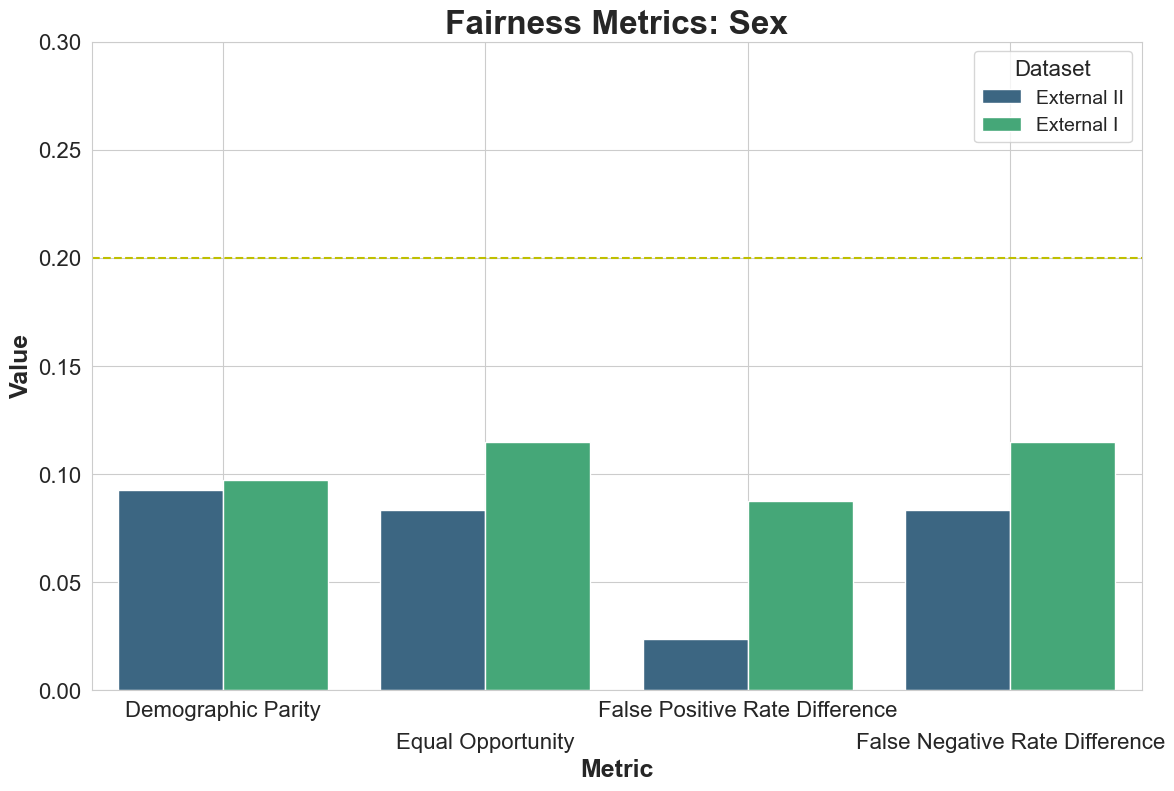

In [32]:
fair_trace_list = fair_trace['Sex']
fair_ext_list = fair_ext['Sex']

# Predict probabilities for the trace and external datasets
probs = best_model['model'].predict_proba(X_trace)[:,1]
probs_trace = np.where(probs > best_model['threshold'], 1, 0)

probs = best_model['model'].predict_proba(X_ext)[:,1]
probs_ext = np.where(probs > best_model['threshold'], 1, 0)

# Compute fairness metrics for both datasets using the function from fairlearn
metrics_trace = fairness_metrics_with_fairlearn(probs_trace, np.array(y_trace).flatten(), fair_trace_list)
metrics_ext = fairness_metrics_with_fairlearn(probs_ext, np.array(y_ext).flatten(), fair_ext_list)

metrics_names = [
    "Demographic Parity", 
    "Equal Opportunity", 
    "False Positive Rate Difference", 
    "False Negative Rate Difference"
]

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Metric': metrics_names * 2,
    'Value': metrics_trace + metrics_ext,
    'Dataset': ['External II'] * len(metrics_names) + ['External I'] * len(metrics_names)
})


# Plotting
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.barplot(data=df, x='Metric', y='Value', hue='Dataset', palette='viridis')

# Set plot details
plt.ylim(0, 0.30)
plt.title('Fairness Metrics: Sex', fontsize=24, fontweight='bold')
plt.xlabel('Metric', fontsize=18, fontweight='bold')
plt.ylabel('Value', fontsize=18, fontweight='bold')
plt.grid(axis='y')
plt.grid(True)
plt.legend(title='Dataset', fontsize=14, title_fontsize=16)

# Adjust x-tick labels for staggering and increase their size
locs, labels = plt.xticks()  # get the current tick locations and labels
plt.setp(labels, rotation=0, fontsize=16)  # set the x-tick labels rotation to 45 degrees and align to the right
for i, label in enumerate(labels):
    position = label.get_position()
    if i % 2 == 0:  # if even index, adjust y-position to be lower
        label.set_position((position[0], position[1]))
    else:  # if odd index, adjust y-position to be higher
        label.set_position((position[0], position[1] - 0.05))

# Adjust the y-tick labels size
plt.yticks(fontsize=16)

# Save the plot
plt.tight_layout()

# Add horizontal lines at y=0.2 and y=-0.2
plt.axhline(y=0.2, color='y', linestyle='--')
#plt.axhline(y=-0.2, color='y', linestyle='--')

plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/fairness_sex_plot_combined{DIS}{FET}.png', dpi=300)

# Show the plot
plt.show()

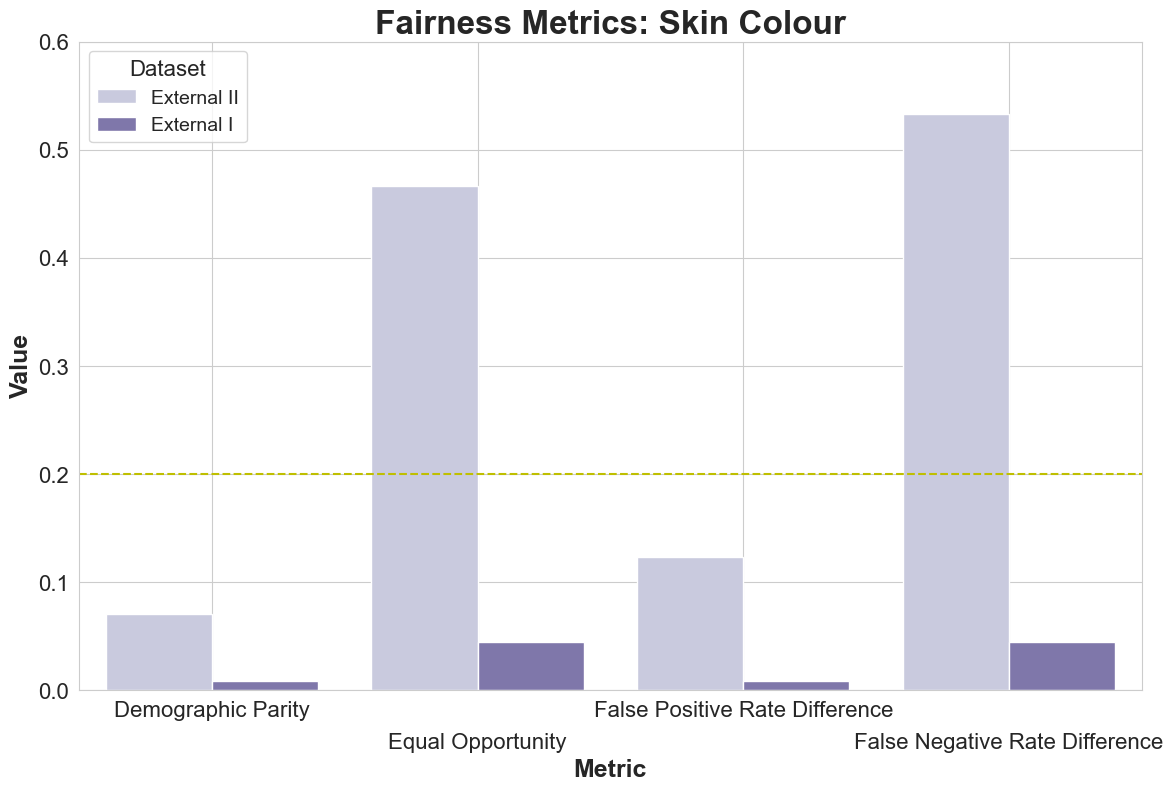

In [34]:
fair_trace_list = fair_trace['Skin_colour']
fair_ext_list = fair_ext['Skin_colour']

# Predict probabilities for the trace and external datasets
probs = best_model['model'].predict_proba(X_trace)[:,1]
probs_trace = np.where(probs > best_model['threshold'], 1, 0)

probs = best_model['model'].predict_proba(X_ext)[:,1]
probs_ext = np.where(probs > best_model['threshold'], 1, 0)

# Convert to numpy arrays
probs_trace = np.array(probs_trace)
y_trace = np.array(y_trace).flatten()
fair_trace_list = np.array(fair_trace_list)

probs_ext = np.array(probs_ext)
y_ext = np.array(y_ext).flatten()
fair_ext_list = np.array(fair_ext_list)

# Identify non-NaN indices for trace
non_nan_indices_trace = ~np.isnan(probs_trace) & ~np.isnan(y_trace) & ~np.isnan(fair_trace_list)

# Filter out NaN values for trace
probs_trace_clean = probs_trace[non_nan_indices_trace]
y_trace_clean = y_trace[non_nan_indices_trace]
fair_trace_list_clean = fair_trace_list[non_nan_indices_trace]

# Identify non-NaN indices for ext
non_nan_indices_ext = ~np.isnan(probs_ext) & ~np.isnan(y_ext) & ~np.isnan(fair_ext_list)

# Filter out NaN values for ext
probs_ext_clean = probs_ext[non_nan_indices_ext]
y_ext_clean = y_ext[non_nan_indices_ext]
fair_ext_list_clean = fair_ext_list[non_nan_indices_ext]

# Now, compute the fairness metrics using the cleaned data
metrics_trace = fairness_metrics_with_fairlearn(probs_trace_clean, y_trace_clean, fair_trace_list_clean)
metrics_ext = fairness_metrics_with_fairlearn(probs_ext_clean, y_ext_clean, fair_ext_list_clean)

metrics_names = [
    "Demographic Parity", 
    "Equal Opportunity", 
    "False Positive Rate Difference", 
    "False Negative Rate Difference"
]

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Metric': metrics_names * 2,
    'Value': metrics_trace + metrics_ext,
    'Dataset': ['External II'] * len(metrics_names) + ['External I'] * len(metrics_names)
})


# Plotting
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.barplot(data=df, x='Metric', y='Value', hue='Dataset', palette='Purples')

# Set plot details
plt.ylim(0, 0.60)
plt.title('Fairness Metrics: Skin Colour', fontsize=24, fontweight='bold')
plt.xlabel('Metric', fontsize=18, fontweight='bold')
plt.ylabel('Value', fontsize=18, fontweight='bold')
plt.grid(axis='y')
plt.grid(True)
plt.legend(title='Dataset', fontsize=14, title_fontsize=16)

# Adjust x-tick labels for staggering and increase their size
locs, labels = plt.xticks()  # get the current tick locations and labels
plt.setp(labels, rotation=0, fontsize=16)  # set the x-tick labels rotation to 45 degrees and align to the right
for i, label in enumerate(labels):
    position = label.get_position()
    if i % 2 == 0:  # if even index, adjust y-position to be lower
        label.set_position((position[0], position[1]))
    else:  # if odd index, adjust y-position to be higher
        label.set_position((position[0], position[1] - 0.05))

# Adjust the y-tick labels size
plt.yticks(fontsize=16)

# Save the plot
plt.tight_layout()

# Add horizontal lines at y=0.2 and y=-0.2
plt.axhline(y=0.2, color='y', linestyle='--')
#plt.axhline(y=-0.2, color='y', linestyle='--')

plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/fairness_skin_plot_combined{DIS}{FET}.png', dpi=300)

# Show the plot
plt.show()

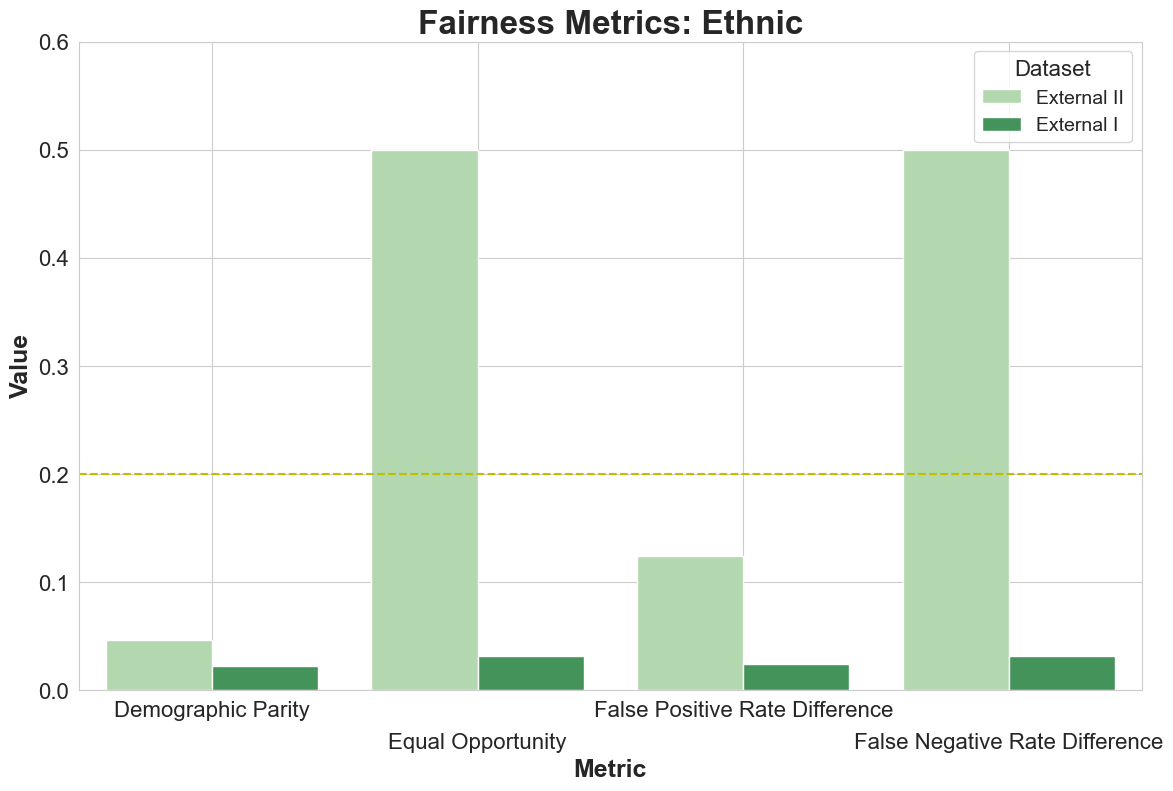

In [35]:
fair_trace_list = fair_trace['Ethnic']
fair_ext_list = fair_ext['Ethnic']

# Predict probabilities for the trace and external datasets
probs = best_model['model'].predict_proba(X_trace)[:,1]
probs_trace = np.where(probs > best_model['threshold'], 1, 0)

probs = best_model['model'].predict_proba(X_ext)[:,1]
probs_ext = np.where(probs > best_model['threshold'], 1, 0)

# Convert to numpy arrays
probs_trace = np.array(probs_trace)
y_trace = np.array(y_trace).flatten()
fair_trace_list = np.array(fair_trace_list)

probs_ext = np.array(probs_ext)
y_ext = np.array(y_ext).flatten()
fair_ext_list = np.array(fair_ext_list)

# Identify non-NaN indices for trace
non_nan_indices_trace = ~np.isnan(probs_trace) & ~np.isnan(y_trace) & ~np.isnan(fair_trace_list)

# Filter out NaN values for trace
probs_trace_clean = probs_trace[non_nan_indices_trace]
y_trace_clean = y_trace[non_nan_indices_trace]
fair_trace_list_clean = fair_trace_list[non_nan_indices_trace]

# Identify non-NaN indices for ext
non_nan_indices_ext = ~np.isnan(probs_ext) & ~np.isnan(y_ext) & ~np.isnan(fair_ext_list)

# Filter out NaN values for ext
probs_ext_clean = probs_ext[non_nan_indices_ext]
y_ext_clean = y_ext[non_nan_indices_ext]
fair_ext_list_clean = fair_ext_list[non_nan_indices_ext]

# Now, compute the fairness metrics using the cleaned data
metrics_trace = fairness_metrics_with_fairlearn(probs_trace_clean, y_trace_clean, fair_trace_list_clean)
metrics_ext = fairness_metrics_with_fairlearn(probs_ext_clean, y_ext_clean, fair_ext_list_clean)

metrics_names = [
    "Demographic Parity", 
    "Equal Opportunity", 
    "False Positive Rate Difference", 
    "False Negative Rate Difference"
]

# Note: I removed "True Negative Rate Difference" from metrics_names as it's not directly computed using fairlearn.

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Metric': metrics_names * 2,
    'Value': metrics_trace + metrics_ext,
    'Dataset': ['External II'] * len(metrics_names) + ['External I'] * len(metrics_names)
})


# Plotting
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.barplot(data=df, x='Metric', y='Value', hue='Dataset', palette='Greens')

# Set plot details
plt.ylim(0, 0.60)
plt.title('Fairness Metrics: Ethnic', fontsize=24, fontweight='bold')
plt.xlabel('Metric', fontsize=18, fontweight='bold')
plt.ylabel('Value', fontsize=18, fontweight='bold')
plt.grid(axis='y')
plt.grid(True)
plt.legend(title='Dataset', fontsize=14, title_fontsize=16)

# Adjust x-tick labels for staggering and increase their size
locs, labels = plt.xticks()  # get the current tick locations and labels
plt.setp(labels, rotation=0, fontsize=16)  # set the x-tick labels rotation to 45 degrees and align to the right
for i, label in enumerate(labels):
    position = label.get_position()
    if i % 2 == 0:  # if even index, adjust y-position to be lower
        label.set_position((position[0], position[1]))
    else:  # if odd index, adjust y-position to be higher
        label.set_position((position[0], position[1] - 0.05))

# Adjust the y-tick labels size
plt.yticks(fontsize=16)

# Save the plot
plt.tight_layout()

# Add horizontal lines at y=0.2 and y=-0.2
plt.axhline(y=0.2, color='y', linestyle='--')
#plt.axhline(y=-0.2, color='y', linestyle='--')

plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/fairness_ethnic_plot_combined{DIS}{FET}.png', dpi=300)

# Show the plot
plt.show()